---
title: "OOD Detection: Overview, Output-Based Methods"
teaching: 0
exercises: 0
---

### Questions

- What are out-of-distribution (OOD) data and why is detecting them important in machine learning models?
- How do output-based methods like softmax and energy-based methods work for OOD detection?
- What are the limitations of output-based OOD detection methods?

### Objectives

- Understand the concept of out-of-distribution data and its significance in building trustworthy machine learning models.
- Learn about different output-based methods for OOD detection, including softmax and energy-based methods
- Identify the strengths and limitations of output-based OOD detection techniques.

# Introduction to Out-of-Distribution (OOD) Data
## What is OOD data?
Out-of-distribution (OOD) data refers to data that significantly differs from the training data on which a machine learning model was built. The difference can arise from either:

- Semantic shift: OOD sample is drawn from a class that was not present during training
- Covariate shift: OOD sample is drawn from a different domain; input feature distribution is drastically different than training data

**TODO**: Add closed/open-world image similar to Sharon Li's tutorial at 4:28: https://www.youtube.com/watch?v=hgLC9_9ZCJI

## Why does OOD data matter?
Models trained on a specific distribution might make incorrect predictions on OOD data, leading to unreliable outputs. In critical applications (e.g., healthcare, autonomous driving), encountering OOD data without proper handling can have severe consequences.

### Ex1: Tesla crashes into jet
In April 2022, a [Tesla Model Y crashed into a $3.5 million private jet](https://www.newsweek.com/video-tesla-smart-summon-mode-ramming-3m-jet-viewed-34m-times-1700310 ) at an aviation trade show in Spokane, Washington, while operating on the "Smart Summon" feature. The feature allows Tesla vehicles to autonomously navigate parking lots to their owners, but in this case, it resulted in a significant mishap.
- The Tesla was summoned by its owner using the Tesla app, which requires holding down a button to keep the car moving. The car continued to move forward even after making contact with the jet, pushing the expensive aircraft and causing notable damage.
- The crash highlighted several issues with Tesla's Smart Summon feature, particularly its object detection capabilities. The system failed to recognize and appropriately react to the presence of the jet, a problem that has been observed in other scenarios where the car's sensors struggle with objects that are lifted off the ground or have unusual shapes.


### Ex2: IBM Watson for Oncology
IBM Watson for Oncology faced several issues due to OOD data. The system was primarily trained on data from Memorial Sloan Kettering Cancer Center (MSK), which did not generalize well to other healthcare settings. This led to the following problems:
1. Unsafe Recommendations: Watson for Oncology provided treatment recommendations that were not safe or aligned with standard care guidelines in many cases outside of MSK. This happened because the training data was not representative of the diverse medical practices and patient populations in different regions
2. Bias in Training Data: The system's recommendations were biased towards the practices at MSK, failing to account for different treatment protocols and patient needs elsewhere. This bias is a classic example of an OOD issue, where the model encounters data (patients and treatments) during deployment that significantly differ from its training data

### Ex3: Doctors using GPT3
#### Misdiagnosis and Inaccurate Medical Advice
In various studies and real-world applications, GPT-3 has been shown to generate inaccurate medical advice when faced with OOD data. This can be attributed to the fact that the training data, while extensive, does not cover all possible medical scenarios and nuances, leading to hallucinations or incorrect responses when encountering unfamiliar input.

A [study published by researchers at Stanford](https://hai.stanford.edu/news/generating-medical-errors-genai-and-erroneous-medical-references) found that GPT-3, even when using retrieval-augmented generation, provided unsupported medical advice in about 30% of its statements. For example, it suggested the use of a specific dosage for a defibrillator based on monophasic technology, while the cited source only discussed biphasic technology, which operates differently.

#### Fake Medical Literature References
Another critical OOD issue is the generation of fake or non-existent medical references by LLMs. When LLMs are prompted to provide citations for their responses, they sometimes generate references that sound plausible but do not actually exist. This can be particularly problematic in academic and medical contexts where accurate sourcing is crucial.

In [evaluations of GPT-3's ability to generate medical literature references](https://hai.stanford.edu/news/generating-medical-errors-genai-and-erroneous-medical-references) , it was found that a significant portion of the references were either entirely fabricated or did not support the claims being made. This was especially true for complex medical inquiries that the model had not seen in its training data.


# Detecting and Handling OOD Data
Given the problems posed by OOD data, a reliable model should identify such instances, and then either:
1. Reject them during inference
2. Hand them off to a model trained on a more similar distribution (an in-distribution)

How can we determine whether a given instance is OOD or ID? Over the past several years, there have been a wide assortment of new methods developed to tackle this task. In this episode, we will cover a few of the most common approaches and discuss advantages/disadvantages of each.


## Threshold-based methods
Threshold-based methods are one of the simplest and most intuitive approaches for detecting out-of-distribution (OOD) data. The central idea is to define a threshold on a certain score or confidence measure, beyond which the data point is considered out-of-distribution. Typically, these scores are derived from the model's output probabilities or other statistical measures of uncertainty. Common approaches include:

### Output-based thresholds

Output-based Out-of-Distribution (OOD) detection refers to methods that determine whether a given input is out-of-distribution based on the output of a trained model. These methods typically analyze the model's confidence scores, energy scores, or other output metrics to identify data points that are unlikely to belong to the distribution the model was trained on. The main approaches within output-based OOD detection include:

- Softmax Scores: The softmax output of a neural network represents the predicted probabilities for each class. A common threshold-based method involves setting a confidence threshold, and if the maximum softmax score of an instance falls below this threshold, it is flagged as OOD.
- Energy: Energy measures the uncertainty in the predicted probability distribution. High energy indicates high uncertainty. By setting a threshold on the energy value, instances with energy above the threshold can be classified as OOD.
- Distance: This method calculates the distance of an instance from the distribution of training data features learned by the model. If the distance is beyond a certain threshold, the instance is considered OOD.

We will cover the first two methods (softmax and energy) in this episode and then do a deep dive into distance-based methods in the next episode.

# Example 1: Softmax scores
In this first example, we will train a simgle linear regression model to classify images as T-shirts or pants. We will then evaluate how our model reacts to data outside of these two classes ("semantic shift").

In [2]:
# some settings I'm playing around with when designing this lesson
verbose = False
alpha=0.2
max_iter = 10 # increase after testing phase
n_epochs = 10 # increase after testing phase


### Prepare the ID (train and test) and OOD data
* ID = T-shirts/Blouses, Pants
* OOD = any other class. For Illustrative purposes, we'll focus on images of sandals as the OOD class.

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ood_data.shape=(1000, 28, 28)
train_data.shape=(12000, 28, 28)
test_data.shape=(2000, 28, 28)


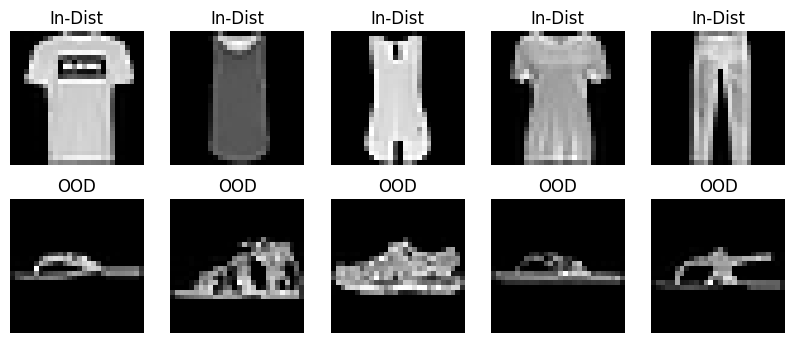

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# # Define classes for simplicity
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Prepare OOD data - Sandals (5)
ood_data = test_images[test_labels == 5]
ood_labels = test_labels[test_labels == 5]
print(f'ood_data.shape={ood_data.shape}')

# Filter data for T-shirts (0) and Trousers (1) as in-distribution
train_filter = np.isin(train_labels, [0, 1])
test_filter = np.isin(test_labels, [0, 1])

train_data = train_images[train_filter]
train_labels = train_labels[train_filter]
print(f'train_data.shape={train_data.shape}')

test_data = test_images[test_filter]
test_labels = test_labels[test_filter]
print(f'test_data.shape={test_data.shape}')

# Display examples of in-distribution and OOD data
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_data[i], cmap='gray')
    plt.title("In-Dist")
    plt.axis('off')
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(ood_data[i], cmap='gray')
    plt.title("OOD")
    plt.axis('off')
plt.show()


In [4]:
train_labels[0:5] # shirts are 0s, pants are 1s

array([0, 0, 0, 0, 1], dtype=uint8)

## Visualizing OOD and ID data

### PCA
PCA visualization can provide insights into how well a model is separating ID and OOD data. If the OOD data overlaps significantly with ID data in the PCA space, it might indicate that the model could struggle to correctly identify OOD samples.

**Focus on Linear Relationships**: PCA is a linear dimensionality reduction technique. It assumes that the directions of maximum variance in the data can be captured by linear combinations of the original features. This can be a limitation when the data has complex, non-linear relationships, as PCA may not capture the true structure of the data. However, if you're using a linear model (as we are here), PCA can be more appropriate for visualizing in-distribution (ID) and out-of-distribution (OOD) data because both PCA and linear models operate under linear assumptions. PCA will effectively capture the main variance in the data as seen by the linear model, making it easier to understand the decision boundaries and how OOD data deviates from the ID data within those boundaries.

In [5]:
# Flatten images for PCA and logistic regression
train_data_flat = train_data.reshape((train_data.shape[0], -1))
test_data_flat = test_data.reshape((test_data.shape[0], -1))
ood_data_flat = ood_data.reshape((ood_data.shape[0], -1))

print(f'train_data_flat.shape={train_data_flat.shape}')
print(f'test_data_flat.shape={test_data_flat.shape}')
print(f'ood_data_flat.shape={ood_data_flat.shape}')

train_data_flat.shape=(12000, 784)
test_data_flat.shape=(2000, 784)
ood_data_flat.shape=(1000, 784)


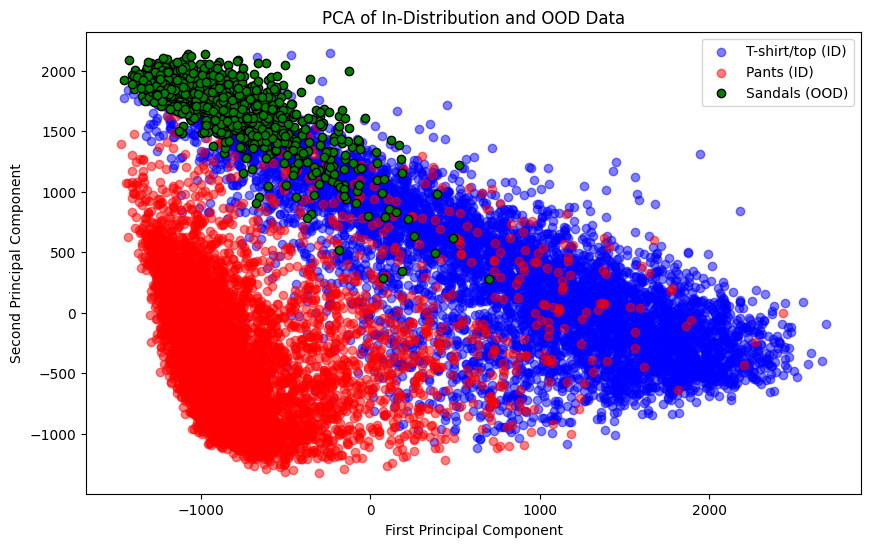

In [6]:
# Perform PCA to visualize the first two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
train_data_pca = pca.fit_transform(train_data_flat)
test_data_pca = pca.transform(test_data_flat)
ood_data_pca = pca.transform(ood_data_flat)

# Plotting PCA components
plt.figure(figsize=(10, 6))
scatter1 = plt.scatter(train_data_pca[train_labels == 0, 0], train_data_pca[train_labels == 0, 1], c='blue', label='T-shirt/top (ID)', alpha=0.5)
scatter2 = plt.scatter(train_data_pca[train_labels == 1, 0], train_data_pca[train_labels == 1, 1], c='red', label='Pants (ID)', alpha=0.5)
scatter3 = plt.scatter(ood_data_pca[:, 0], ood_data_pca[:, 1], c='green', label='Sandals (OOD)', edgecolor='k')

# Create a single legend for all classes
plt.legend(handles=[scatter1, scatter2, scatter3], loc="upper right")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of In-Distribution and OOD Data')
plt.show()

From this plot, we see that sandals are more likely to be confused as T-shirts than pants. It also may be surprising to see that these data clouds overlap so much given their semantic differences. Why might this be?
* **Over-reliance on linear relationships**: Part of this has to do with the fact that we're only looking at linear relationships and treating each pixel as its own input feature, which is usually never a great idea when working with image data. In our next example, we'll switch to the more modern approach of CNNs.
* **Semantic gap != feature gap**: Another factor of note is that images that have a wide semantic gap may not necessarily translate to a wide gap in terms of the data's visual features (e.g., ankle boots and bags might both be small, have leather, and have zippers). Part of an effective OOD detection scheme involves thinking carefully about what sorts of data contanimations may be observed by the model, and assessing how similar these contaminations may be to your desired class labels.

## Train and evaluate model on ID data

In [7]:
# Train a logistic regression classifier
model = LogisticRegression(max_iter=max_iter, solver='lbfgs', multi_class='multinomial').fit(train_data_flat, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Before we worry about the impact of OOD data, let's first verify that we have a reasonably accurate model for the ID data.

In [8]:
# Evaluate the model on in-distribution data
in_dist_preds = model.predict(test_data_flat)
in_dist_accuracy = accuracy_score(test_labels, in_dist_preds)
print(f'In-Distribution Accuracy: {in_dist_accuracy:.2f}')

In-Distribution Accuracy: 0.98


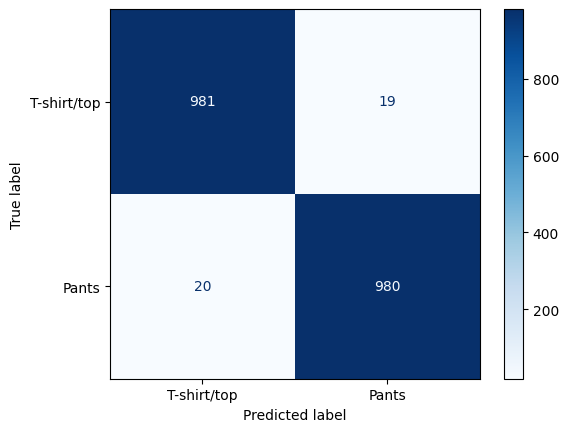

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Generate and display confusion matrix
cm = confusion_matrix(test_labels, in_dist_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt/top', 'Pants'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

## How does our model view OOD data?

A basic question we can start with is to ask, on average, how are OOD samples classified? Are they more likely to be Tshirts or pants? For this kind of question, we can calculate the probability scores for the OOD data, and compare this to the ID data.

In [10]:
# Predict probabilities using the model on OOD data (Sandals)
ood_probs = model.predict_proba(ood_data_flat)
avg_ood_prob = np.mean(ood_probs, 0)
print(f"Avg. probability of sandal being T-shirt: {avg_ood_prob[0]:.4f}")
print(f"Avg. probability of sandal being pants: {avg_ood_prob[1]:.4f}")

id_probs = model.predict_proba(train_data_flat)
id_probs_shirts = id_probs[train_labels==0,:]
id_probs_pants = id_probs[train_labels==1,:]
avg_tshirt_prob = np.mean(id_probs_shirts, 0)
avg_pants_prob = np.mean(id_probs_pants, 0)

print()
print(f"Avg. probability of T-shirt being T-shirt: {avg_tshirt_prob[0]:.4f}")
print(f"Avg. probability of pants being pants: {avg_pants_prob[1]:.4f}")

Avg. probability of sandal being T-shirt: 0.5493
Avg. probability of sandal being pants: 0.4507

Avg. probability of T-shirt being T-shirt: 0.9576
Avg. probability of pants being pants: 0.9804


Based on the difference in averages here, it looks like softmax may provide at least a somewhat useful signal in separating ID and OOD data. Let's take a closer look by plotting histograms of all probability scores across our classes of interest (ID-Tshirt, ID-Pants, and OOD).

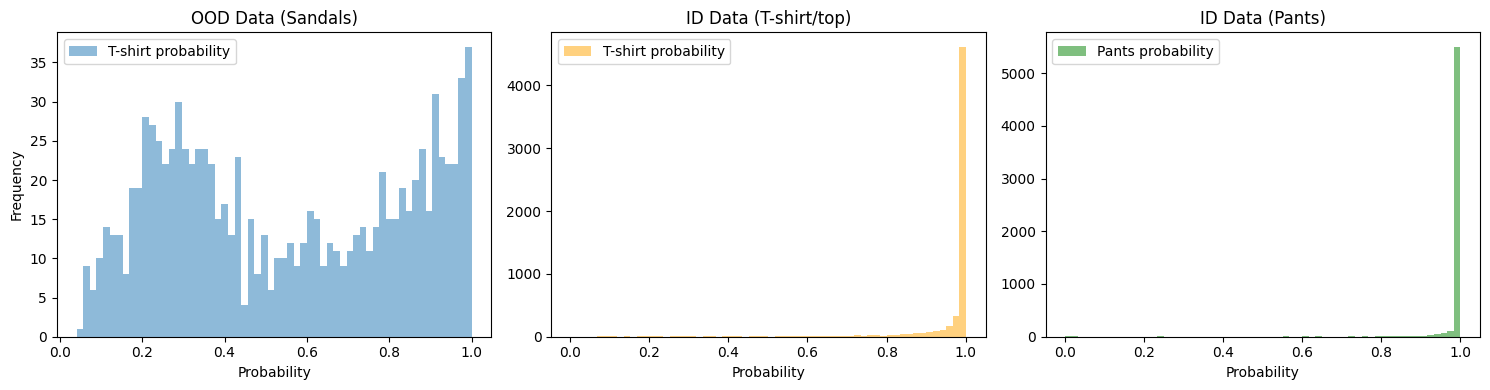

In [11]:
import matplotlib.pyplot as plt

# Creating the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
bins=60
# Plotting the histogram of probabilities for OOD data (Sandals)
axes[0].hist(ood_probs[:, 0], bins=bins, alpha=0.5, label='T-shirt probability')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('OOD Data (Sandals)')
axes[0].legend()

# Plotting the histogram of probabilities for ID data (T-shirt)
axes[1].hist(id_probs_shirts[:, 0], bins=bins, alpha=0.5, label='T-shirt probability', color='orange')
axes[1].set_xlabel('Probability')
axes[1].set_title('ID Data (T-shirt/top)')
axes[1].legend()

# Plotting the histogram of probabilities for ID data (Pants)
axes[2].hist(id_probs_pants[:, 1], bins=bins, alpha=0.5, label='Pants probability', color='green')
axes[2].set_xlabel('Probability')
axes[2].set_title('ID Data (Pants)')
axes[2].legend()

# Adjusting layout
plt.tight_layout()

# Displaying the plot
plt.show()


Alternatively, for a better comparison across all three classes, we can use a probability density plot. This will allow for an easier comparison when the counts across classes lie on vastly different sclaes (i.e., max of 35 vs max of 5000).

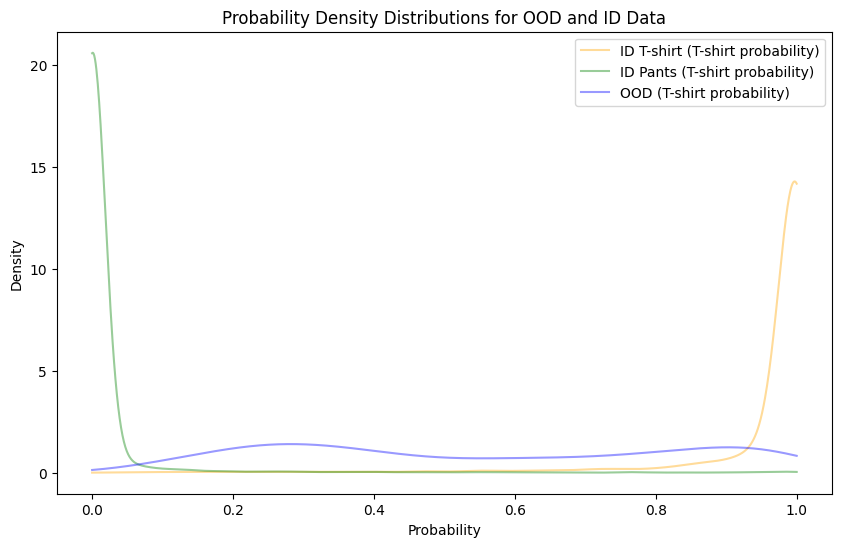

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Create figure
plt.figure(figsize=(10, 6))

# Define bins
alpha = 0.4

# Plot PDF for ID T-shirt (T-shirt probability)
density_id_shirts = gaussian_kde(id_probs_shirts[:, 0])
x_id_shirts = np.linspace(0, 1, 1000)
plt.plot(x_id_shirts, density_id_shirts(x_id_shirts), label='ID T-shirt (T-shirt probability)', color='orange', alpha=alpha)

# Plot PDF for ID Pants (Pants probability)
density_id_pants = gaussian_kde(id_probs_pants[:, 0])
x_id_pants = np.linspace(0, 1, 1000)
plt.plot(x_id_pants, density_id_pants(x_id_pants), label='ID Pants (T-shirt probability)', color='green', alpha=alpha)

# Plot PDF for OOD (T-shirt probability)
density_ood = gaussian_kde(ood_probs[:, 0])
x_ood = np.linspace(0, 1, 1000)
plt.plot(x_ood, density_ood(x_ood), label='OOD (T-shirt probability)', color='blue', alpha=alpha)

# Adding labels and title
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Probability Density Distributions for OOD and ID Data')
plt.legend()

# Displaying the plot
plt.show()


Unfortunately, we observe a significant amount of overlap between OOD data and high T-shirt probability. Furthermore, the blue line doesn't seem to decrease much as you move from 0.9 to 1, suggesting that even a very high threshold is likely to lead to OOD contamination (while also tossing out a significant portion of ID data).

For pants, the problem is much less severe. It looks like a low threshold (on this T-shirt probability scale) can separate nearly all OOD samples from being pants.

### Setting a threshold
Let's put our observations to the test and produce a confusion matrix that includes ID-pants, ID-Tshirts, and OOD class labels. We'll start with a high threshold of 0.9 to see how that performs.

In [13]:
def softmax_thresh_classifications(probs, threshold):
  classifications = np.where(probs[:, 1] >= threshold, 1,  # classified as pants
                               np.where(probs[:, 0] >= threshold, 0,  # classified as shirts
                                        -1))  # classified as OOD
  return classifications

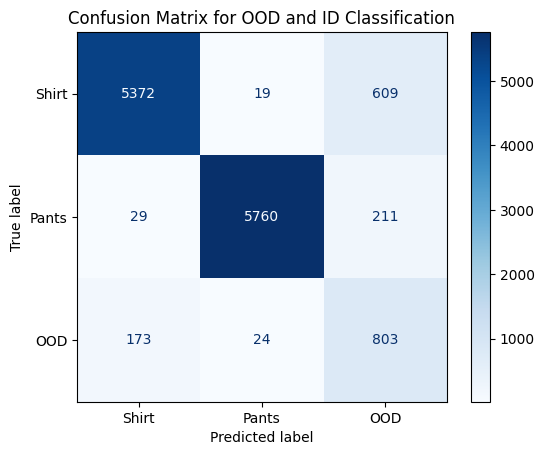

F1: 0.9521552930144124
Precision: 0.978175177693188
Recall: 0.9276666666666666


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support


# Assuming ood_probs, id_probs, and train_labels are defined
# Threshold values
upper_threshold = 0.9

# Classifying OOD examples (sandals)
ood_classifications = softmax_thresh_classifications(ood_probs, upper_threshold)

# Classifying ID examples (T-shirts and pants)
id_classifications = softmax_thresh_classifications(id_probs, upper_threshold)

# Combine OOD and ID classifications and true labels
all_predictions = np.concatenate([ood_classifications, id_classifications])
all_true_labels = np.concatenate([-1 * np.ones(ood_classifications.shape), train_labels])

# Confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions, labels=[0, 1, -1])

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Shirt", "Pants", "OOD"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for OOD and ID Classification')
plt.show()

# Looking at F1, precision, and recall

precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, labels=[0, 1], average='macro') # discuss macro vs micro .

print(f"F1: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Even with a high threshold of 0.9, we end up with nearly a couple hundred OOD samples classified as ID. In addition, over 800 ID samples had to be tossed out due to uncertainty.

### Quick exercise
What threhsold is required to ensure that no OOD samples are incorrectly considered as IID? What percentage of ID samples are mistaken as OOD at this threshold? Answer:  0.9999, (3826+2414)/(3826+2414+2174+3586)=52%

With a very conservative threshold, we can make sure very few OOD samples are incorrectly classified as ID. However, the flip side is that conservative thresholds tend to incorrectly classify many ID samples as being OOD. In this case, we incorrectly assume almost 20% of shirts are OOD samples.

## Iterative Threshold Determination

In practice, selecting an appropriate threshold is an iterative process that balances the trade-off between correctly identifying in-distribution (ID) data and accurately flagging out-of-distribution (OOD) data. Here's how you can iteratively determine the threshold:

* **Define Evaluation Metrics**: While confusion matrices are an excellent tool when you're ready to more closely examine the data, we need a single metric that can summarize threshold performance so we can easily compare across threshold. Common metrics include accuracy, precision, recall, or the F1 score for both ID and OOD detection.

* **Evaluate Over a Range of Thresholds**: Test different threshold values and evaluate the performance on a validation set containing both ID and OOD data.

* **Select the Optimal Threshold**: Choose the threshold that provides the best balance according to your chosen metrics.

Use the below code to determine what threshold should be set to ensure precision = 100%. What threshold is required for recall to be 100%? What threshold gives the highest F1 score?

### Callout on averaging schemes
F1 scores can be calculated per class, and then averaged in different ways (macro, micro, or weighted) when dealing with multiclass or multilabel classification problems. Here are the key types of averaging methods:

* Macro-Averaging: Calculates the F1 score for each class independently and then takes the average of these scores. This treats all classes equally, regardless of their support (number of true instances for each class).

* Micro-Averaging: Aggregates the contributions of all classes to compute the average F1 score. This is typically used for imbalanced datasets as it gives more weight to classes with more instances.

* Weighted-Averaging: Calculates the F1 score for each class independently and then takes the average, weighted by the number of true instances for each class. This accounts for class imbalance by giving more weight to classes with more instances.

### Callout on including OOD data in F1 calculation


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def eval_softmax_thresholds(ood_probs, id_probs):
  # Define thresholds to evaluate
  thresholds = np.linspace(.5, 1, 50)

  # Store evaluation metrics for each threshold
  precisions = []
  recalls = []
  f1_scores = []

  for threshold in thresholds:

    # Classifying OOD examples (sandals)
    ood_classifications = softmax_thresh_classifications(ood_probs, threshold)

    # Classifying ID examples (T-shirts and pants)
    id_classifications = softmax_thresh_classifications(id_probs, threshold)

    # Combine OOD and ID classifications and true labels
    all_predictions = np.concatenate([ood_classifications, id_classifications])
    all_true_labels = np.concatenate([-1 * np.ones(ood_classifications.shape), train_labels])

    # Evaluate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, labels=[0, 1], average='macro') # discuss macro vs micro .
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

  # Find the best thresholds for each metric
  best_f1_index = np.argmax(f1_scores)
  best_f1_threshold = thresholds[best_f1_index]

  best_precision_index = np.argmax(precisions)
  best_precision_threshold = thresholds[best_precision_index]

  best_recall_index = np.argmax(recalls)
  best_recall_threshold = thresholds[best_recall_index]

  print(f"Best F1 threshold: {best_f1_threshold}, F1 Score: {f1_scores[best_f1_index]}")
  print(f"Best Precision threshold: {best_precision_threshold}, Precision: {precisions[best_precision_index]}")
  print(f"Best Recall threshold: {best_recall_threshold}, Recall: {recalls[best_recall_index]}")

  # Plot metrics as functions of the threshold
  plt.figure(figsize=(12, 8))
  plt.plot(thresholds, precisions, label='Precision', color='g')
  plt.plot(thresholds, recalls, label='Recall', color='b')
  plt.plot(thresholds, f1_scores, label='F1 Score', color='r')

  # Add best threshold indicators
  plt.axvline(x=best_f1_threshold, color='r', linestyle='--', label=f'Best F1 Threshold: {best_f1_threshold:.2f}')
  plt.axvline(x=best_precision_threshold, color='g', linestyle='--', label=f'Best Precision Threshold: {best_precision_threshold:.2f}')
  plt.axvline(x=best_recall_threshold, color='b', linestyle='--', label=f'Best Recall Threshold: {best_recall_threshold:.2f}')

  plt.xlabel('Threshold')
  plt.ylabel('Metric Value')
  plt.title('Evaluation Metrics as Functions of Threshold')
  plt.legend()
  plt.show()

  return best_f1_threshold, best_precision_threshold, best_recall_threshold

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best F1 threshold: 0.8163265306122449, F1 Score: 0.9575459439354607
Best Precision threshold: 0.9897959183673469, Precision: 0.9962877373392596
Best Recall threshold: 0.5, Recall: 0.9815


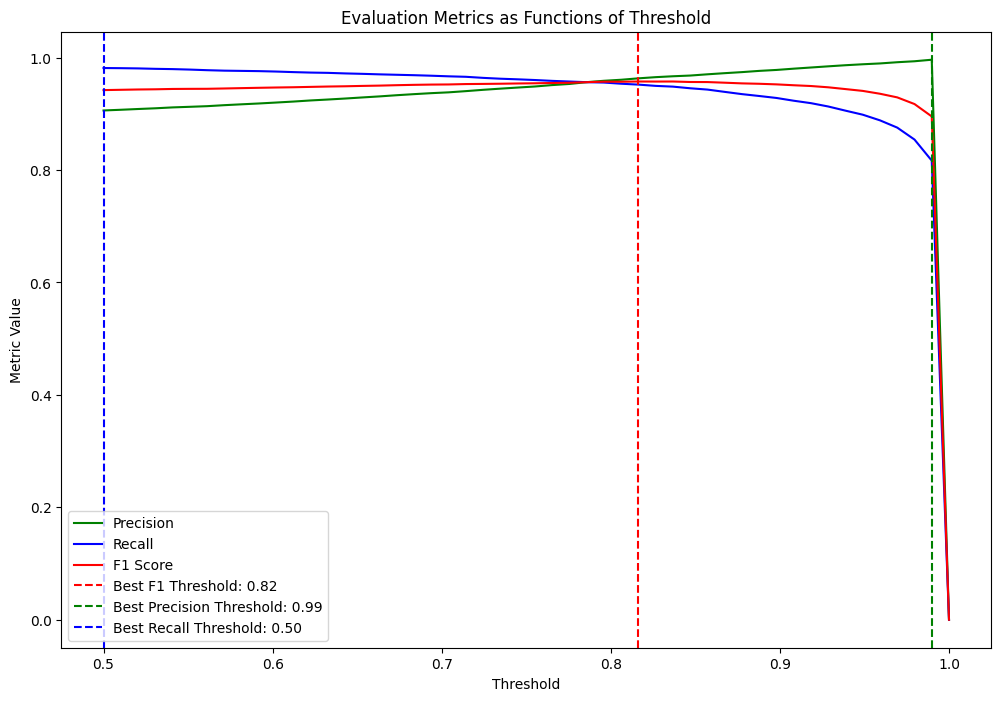

In [19]:
best_f1_threshold, best_precision_threshold, best_recall_threshold = eval_softmax_thresholds(ood_probs, id_probs)

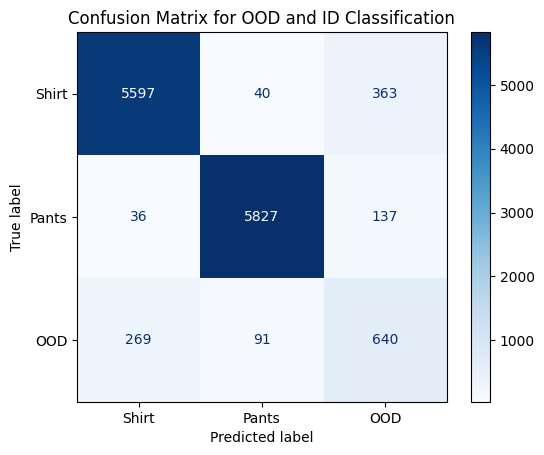

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming ood_probs, id_probs, and train_labels are defined
# Threshold values
upper_threshold = best_f1_threshold
# upper_threshold = best_precision_threshold

# Classifying OOD examples (sandals)
ood_classifications = softmax_thresh_classifications(ood_probs, upper_threshold)

# Classifying ID examples (T-shirts and pants)
id_classifications = softmax_thresh_classifications(id_probs, upper_threshold)

# Combine OOD and ID classifications and true labels
all_predictions = np.concatenate([ood_classifications, id_classifications])
all_true_labels = np.concatenate([-1 * np.ones(ood_classifications.shape), train_labels])

# Confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions, labels=[0, 1, -1])

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Shirt", "Pants", "OOD"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for OOD and ID Classification')
plt.show()


# Example 2: Energy-Based OOD Detection

Liu et al., Energy-based Out-of-distribution Detection, NeurIPS 2020; https://arxiv.org/pdf/2010.03759

* E(x, y) = energy value

* if x and y are "compatitble", lower energy

* Energy can be turned into probability through Gibbs distribution
    * looks at integral over all possible y's


* With energy scores, ID and OOD distributions become much more separable

* Another "output-based" method like softmax

## PyTorch Out-of-Distribution Detection
There's a Pytorch package for OOD detection! https://pytorch-ood.readthedocs.io/en/latest/info.html


In [21]:
!pip install pytorch-ood

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

### Energy-based is designed to work with neural nets... unpack this.
Let's train a simple CNN model on the FashionMNIST dataset.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from keras.datasets import fashion_mnist
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Load Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Prepare OOD data - Sandals (5)
ood_data = test_images[test_labels == 5]
ood_labels = test_labels[test_labels == 5]
print(f'ood_data.shape={ood_data.shape}')

# Filter data for T-shirts (0) and Trousers (1) as in-distribution
train_filter = np.isin(train_labels, [0, 1])
test_filter = np.isin(test_labels, [0, 1])

train_data = train_images[train_filter]
train_labels = train_labels[train_filter]
print(f'train_data.shape={train_data.shape}')

test_data = test_images[test_filter]
test_labels = test_labels[test_filter]
print(f'test_data.shape={test_data.shape}')


# Convert to PyTorch tensors and normalize
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1) / 255.0
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1) / 255.0
ood_data_tensor = torch.tensor(ood_data, dtype=torch.float32).unsqueeze(1) / 255.0

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = torch.utils.data.TensorDataset(test_data_tensor, test_labels_tensor)
ood_dataset = torch.utils.data.TensorDataset(ood_data_tensor, torch.zeros(ood_data_tensor.shape[0], dtype=torch.long))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=64, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, 128)  # Updated this line
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64*5*5)  # Updated this line
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

train_model(model, train_loader, criterion, optimizer)


ood_data.shape=(1000, 28, 28)
train_data.shape=(12000, 28, 28)
test_data.shape=(2000, 28, 28)
Epoch 1, Loss: 0.07875673990186423
Epoch 2, Loss: 0.029247883949404026
Epoch 3, Loss: 0.020252225404816426
Epoch 4, Loss: 0.015268313754820562
Epoch 5, Loss: 0.011907562400626782


### UMAP (or similar)

However, PCA also has some limitations that might make other techniques, such as Uniform Manifold Approximation and Projection (UMAP), more suitable in certain scenarios:

1. **Focus on Linear Relationships**: PCA is a linear dimensionality reduction technique. It assumes that the directions of maximum variance in the data can be captured by linear combinations of the original features. This can be a limitation when the data has complex, non-linear relationships, as PCA may not capture the true structure of the data.

2. **Overlooked Non-Linear Structures**: OOD data might differ from ID data in non-linear ways that PCA cannot capture. For instance, if OOD data lies in a non-linear manifold that differs from the ID data manifold, PCA may not effectively separate them.

3. **Global Structure vs. Local Structure**: PCA emphasizes capturing the global variance in the data, which might not be ideal if the distinctions between ID and OOD data are subtle and local. In such cases, PCA might not highlight the differences effectively.

4. **Alternative Methods Like UMAP**:
    - **UMAP**: Uniform Manifold Approximation and Projection (UMAP) is a non-linear dimensionality reduction technique that preserves both the global structure and the local neighborhood relationships in the data. UMAP is often better at maintaining the continuity of data points that lie on non-linear manifolds.
    - **Better Clustering**: UMAP tends to provide more meaningful visualizations for clustering tasks, making it easier to identify distinct clusters of ID and OOD data.
    - **Preservation of Local Distances**: UMAP preserves local distances more effectively than PCA, which can be crucial for distinguishing between ID and OOD data that are close in the original high-dimensional space but separate in the underlying manifold.

5. **Visualization Clarity**: UMAP often provides clearer and more interpretable visualizations for complex datasets. It can reveal patterns and structures that PCA might miss, making it a valuable tool for analyzing ID and OOD distributions.



## Model-Dependent Visualization
The choice of visualization technique can align with the nature of the model being used. Here's how you might frame this idea:

* Linear Models and PCA: If you're using a linear model, PCA can be more appropriate for visualizing in-distribution (ID) and out-of-distribution (OOD) data because both PCA and linear models operate under linear assumptions. PCA will effectively capture the main variance in the data as seen by the linear model, making it easier to understand the decision boundaries and how OOD data deviates from the ID data within those boundaries.

* Non-Linear Models and UMAP: For non-linear models, techniques like UMAP are more suitable because they preserve both local and global structures in a non-linear fashion, similar to how non-linear models capture complex relationships in the data. UMAP can provide a more accurate visualization of the data manifold, highlighting distinctions between ID and OOD data that may not be apparent with PCA.

In [7]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.8 MB/s eta 0:00:00


In [8]:
plot_umap = False # leave off for now to save time testing downstream materials
if plot_umap:
  import umap

  # Perform UMAP to visualize the data
  umap_reducer = umap.UMAP(n_components=2, random_state=42)
  combined_data = np.vstack([train_data_flat, ood_data_flat])
  combined_labels = np.hstack([train_labels, np.full(ood_data_flat.shape[0], 2)])  # Use 2 for OOD class

  umap_results = umap_reducer.fit_transform(combined_data)

  # Split the results back into in-distribution and OOD data
  umap_in_dist = umap_results[:len(train_data_flat)]
  umap_ood = umap_results[len(train_data_flat):]

  # Plotting UMAP components
  plt.figure(figsize=(10, 6))

  # Plot in-distribution data
  scatter1 = plt.scatter(umap_in_dist[train_labels == 0, 0], umap_in_dist[train_labels == 0, 1], c='blue', label='T-shirts (ID)', alpha=alpha)
  scatter2 = plt.scatter(umap_in_dist[train_labels == 1, 0], umap_in_dist[train_labels == 1, 1], c='red', label='Trousers (ID)', alpha=alpha)

  # Plot OOD data
  scatter3 = plt.scatter(umap_ood[:, 0], umap_ood[:, 1], c='green', label='Sandals (OOD)', edgecolor='k', alpha=alpha)

  # Create a single legend for all classes
  plt.legend(handles=[scatter1, scatter2, scatter3], loc="upper right")
  plt.xlabel('First UMAP Component')
  plt.ylabel('Second UMAP Component')
  plt.title('UMAP of In-Distribution and OOD Data')
  plt.show()

The warning message indicates that UMAP has overridden the n_jobs parameter to 1 due to the random_state being set. This behavior ensures reproducibility by using a single job. If you want to avoid the warning and still use parallelism, you can remove the random_state parameter. However, removing random_state will mean that the results might not be reproducible.

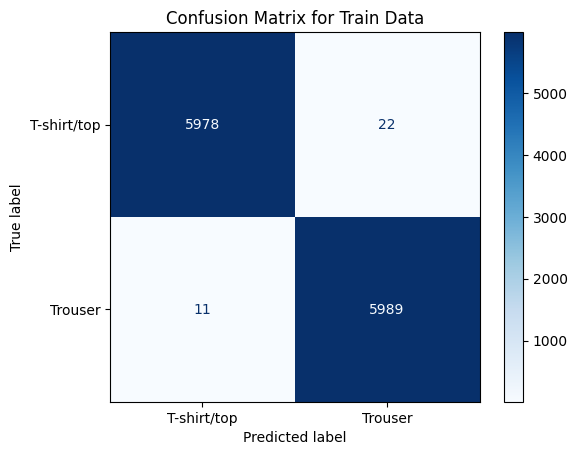

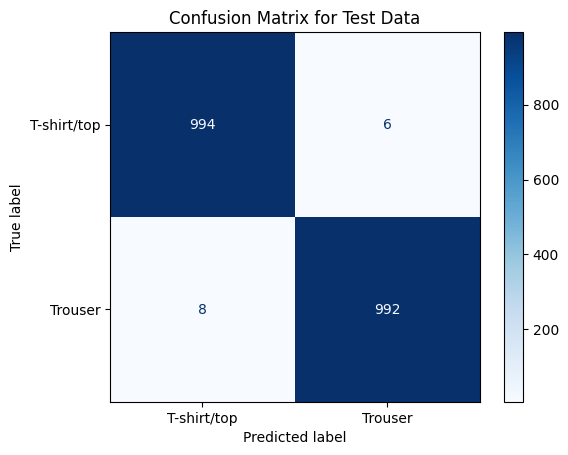

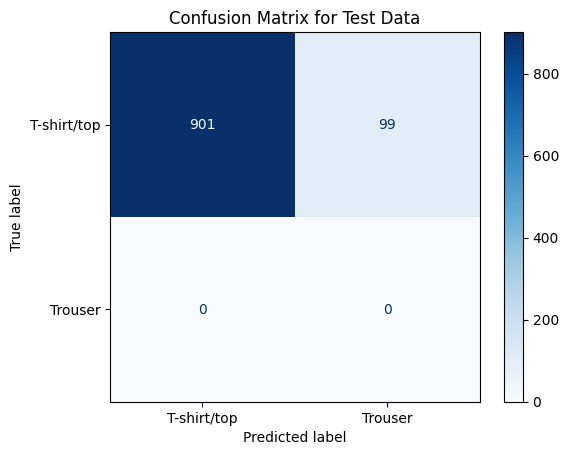

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot confusion matrix
def plot_confusion_matrix(labels, predictions, title):
    cm = confusion_matrix(labels, predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["T-shirt/top", "Trouser"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Function to evaluate model on a dataset
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())
    return np.array(all_labels), np.array(all_predictions)

# Evaluate on train data
train_labels, train_predictions = evaluate_model(model, train_loader, device)
plot_confusion_matrix(train_labels, train_predictions, "Confusion Matrix for Train Data")

# Evaluate on test data
test_labels, test_predictions = evaluate_model(model, test_loader, device)
plot_confusion_matrix(test_labels, test_predictions, "Confusion Matrix for Test Data")

# Evaluate on OOD data
ood_labels, ood_predictions = evaluate_model(model, ood_loader, device)
plot_confusion_matrix(ood_labels, ood_predictions, "Confusion Matrix for Test Data")


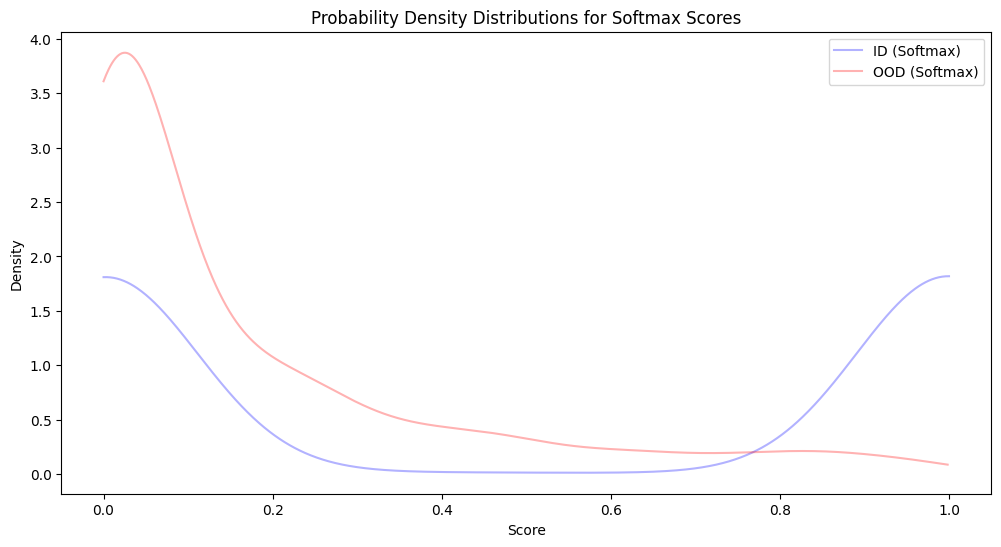

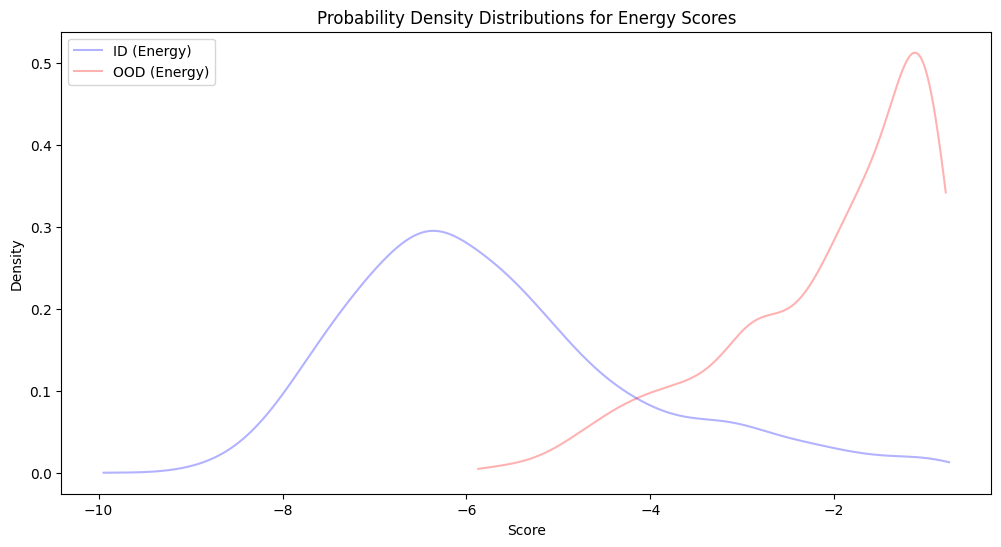

In [24]:
from scipy.stats import gaussian_kde
from pytorch_ood.detector import EnergyBased
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Compute softmax scores
def get_softmax_scores(model, dataloader):
    model.eval()
    softmax_scores = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            softmax = torch.nn.functional.softmax(outputs, dim=1)
            softmax_scores.extend(softmax.cpu().numpy())
    return np.array(softmax_scores)

id_softmax_scores = get_softmax_scores(model, test_loader)
ood_softmax_scores = get_softmax_scores(model, ood_loader)

# Initialize the energy-based OOD detector
energy_detector = EnergyBased(model, t=1.0)

# Compute energy scores
def get_energy_scores(detector, dataloader):
    scores = []
    detector.model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            score = detector.predict(inputs)
            scores.extend(score.cpu().numpy())
    return np.array(scores)

id_energy_scores = get_energy_scores(energy_detector, test_loader)
ood_energy_scores = get_energy_scores(energy_detector, ood_loader)

import matplotlib.pyplot as plt


# Plot PSDs

# Function to plot PSD
def plot_psd(id_scores, ood_scores, method_name):
    plt.figure(figsize=(12, 6))
    alpha = 0.3

    # Plot PSD for ID scores
    id_density = gaussian_kde(id_scores)
    x_id = np.linspace(id_scores.min(), id_scores.max(), 1000)
    plt.plot(x_id, id_density(x_id), label=f'ID ({method_name})', color='blue', alpha=alpha)

    # Plot PSD for OOD scores
    ood_density = gaussian_kde(ood_scores)
    x_ood = np.linspace(ood_scores.min(), ood_scores.max(), 1000)
    plt.plot(x_ood, ood_density(x_ood), label=f'OOD ({method_name})', color='red', alpha=alpha)

    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Probability Density Distributions for {method_name} Scores')
    plt.legend()
    plt.show()

# Plot PSD for softmax scores
plot_psd(id_softmax_scores[:, 1], ood_softmax_scores[:, 1], 'Softmax')

# Plot PSD for energy scores
plot_psd(id_energy_scores, ood_energy_scores, 'Energy')



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Best F1 threshold: -3.0027099093612355, F1 Score: 0.916491974030839
Best Precision threshold: -9.008205097548815, Precision: 1.0
Best Recall threshold: -0.7506492137908936, Recall: 0.9995


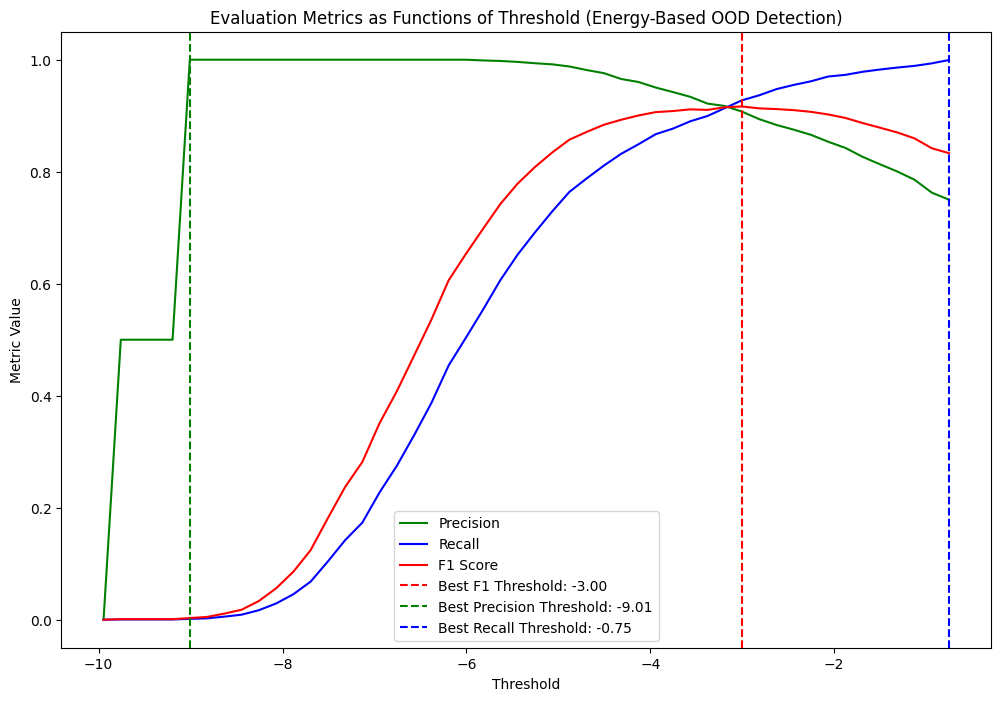

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define thresholds to evaluate
thresholds = np.linspace(id_energy_scores.min(), id_energy_scores.max(), 50)

# Store evaluation metrics for each threshold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# True labels for OOD data (since they are not part of the original labels)
ood_true_labels = np.full(len(ood_energy_scores), -1)

# We need the test_labels to be aligned with the ID data
id_true_labels = test_labels[:len(id_energy_scores)]

for threshold in thresholds:
    # Classify OOD examples based on energy scores
    ood_classifications = np.where(ood_energy_scores >= threshold, -1,  # classified as OOD
                                   np.where(ood_energy_scores < threshold, 0, -1))  # classified as ID

    # Classify ID examples based on energy scores
    id_classifications = np.where(id_energy_scores >= threshold, -1,  # classified as OOD
                                  np.where(id_energy_scores < threshold, id_true_labels, -1))  # classified as ID

    # Combine OOD and ID classifications and true labels
    all_predictions = np.concatenate([ood_classifications, id_classifications])
    all_true_labels = np.concatenate([ood_true_labels, id_true_labels])

    # Evaluate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, labels=[0, 1], average='macro')#, zero_division=0)
    accuracy = accuracy_score(all_true_labels, all_predictions)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Find the best thresholds for each metric
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_index]

best_precision_index = np.argmax(precisions)
best_precision_threshold = thresholds[best_precision_index]

best_recall_index = np.argmax(recalls)
best_recall_threshold = thresholds[best_recall_index]

print(f"Best F1 threshold: {best_f1_threshold}, F1 Score: {f1_scores[best_f1_index]}")
print(f"Best Precision threshold: {best_precision_threshold}, Precision: {precisions[best_precision_index]}")
print(f"Best Recall threshold: {best_recall_threshold}, Recall: {recalls[best_recall_index]}")

# Plot metrics as functions of the threshold
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions, label='Precision', color='g')
plt.plot(thresholds, recalls, label='Recall', color='b')
plt.plot(thresholds, f1_scores, label='F1 Score', color='r')

# Add best threshold indicators
plt.axvline(x=best_f1_threshold, color='r', linestyle='--', label=f'Best F1 Threshold: {best_f1_threshold:.2f}')
plt.axvline(x=best_precision_threshold, color='g', linestyle='--', label=f'Best Precision Threshold: {best_precision_threshold:.2f}')
plt.axvline(x=best_recall_threshold, color='b', linestyle='--', label=f'Best Recall Threshold: {best_recall_threshold:.2f}')

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Evaluation Metrics as Functions of Threshold (Energy-Based OOD Detection)')
plt.legend()
plt.show()


Best F1 threshold: -3.0027099093612355, F1 Score: 0.916491974030839
Best Precision threshold: -9.008205097548815, Precision: 1.0
Best Recall threshold: -0.7506492137908936, Recall: 0.9995


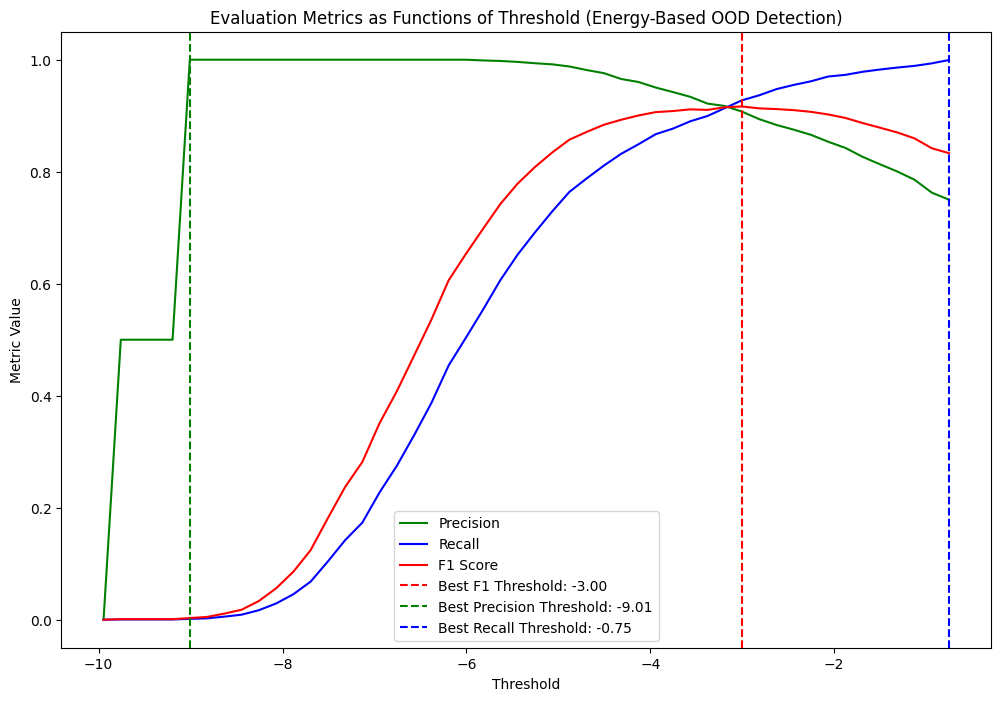

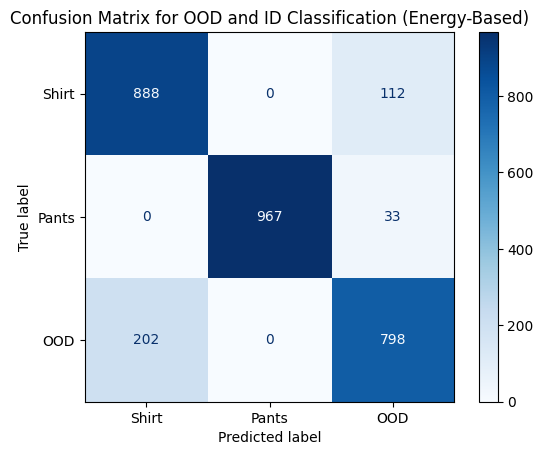

Best F1 threshold: 0.9974874371859297, F1 Score: 0.42688330871491875
Best Precision threshold: 0.9874371859296482, Precision: 0.8751000800640513
Best Recall threshold: 0.5, Recall: 0.501


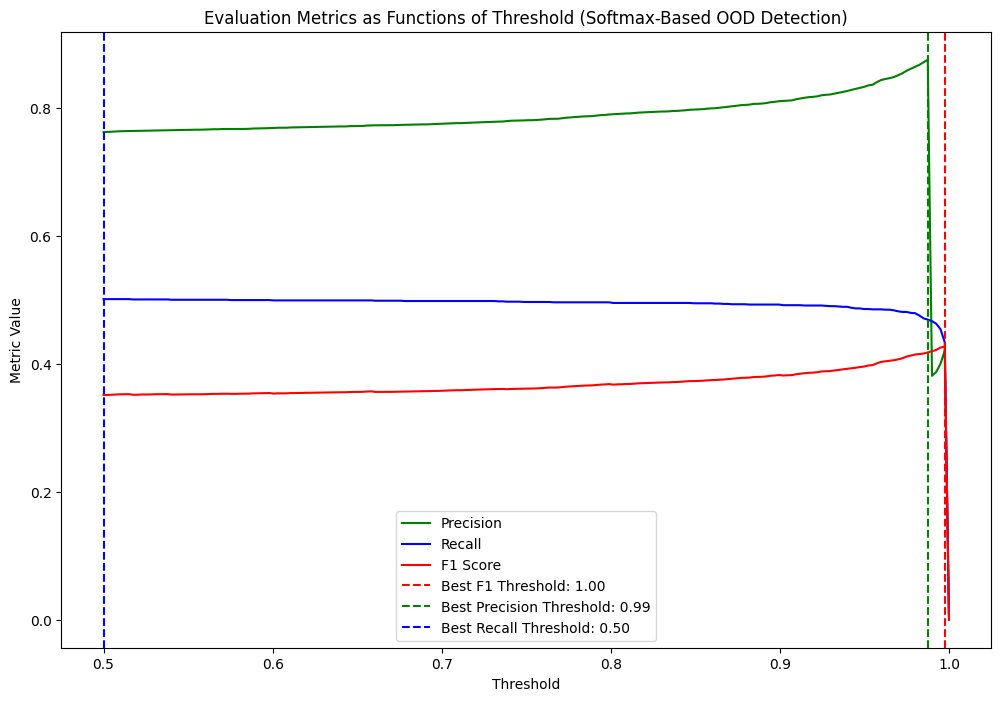

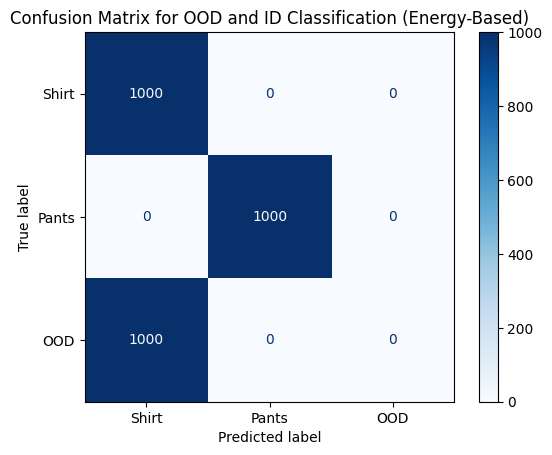

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_ood_detection(id_scores, ood_scores, id_true_labels, id_predictions, ood_predictions, score_type='energy'):
    """
    Evaluate OOD detection based on either energy scores or softmax scores.

    Parameters:
    - id_scores: np.array, scores for in-distribution (ID) data
    - ood_scores: np.array, scores for out-of-distribution (OOD) data
    - id_true_labels: np.array, true labels for ID data
    - id_predictions: np.array, predicted labels for ID data
    - ood_predictions: np.array, predicted labels for OOD data
    - score_type: str, type of score used ('energy' or 'softmax')

    Returns:
    - Best thresholds for F1, Precision, and Recall
    - Plots of Precision, Recall, and F1 Score as functions of the threshold
    """
    # Define thresholds to evaluate
    if score_type == 'softmax':
        thresholds = np.linspace(0.5, 1.0, 200)
    else:
        thresholds = np.linspace(id_scores.min(), id_scores.max(), 50)

    # Store evaluation metrics for each threshold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # True labels for OOD data (since they are not part of the original labels)
    ood_true_labels = np.full(len(ood_scores), -1)

    for threshold in thresholds:
        # Classify OOD examples based on scores
        if score_type == 'energy':
            ood_classifications = np.where(ood_scores >= threshold, -1, ood_predictions)
            id_classifications = np.where(id_scores >= threshold, -1, id_predictions)
        elif score_type == 'softmax':
            ood_classifications = np.where(ood_scores <= threshold, -1, ood_predictions)
            id_classifications = np.where(id_scores <= threshold, -1, id_predictions)
        else:
            raise ValueError("Invalid score_type. Use 'energy' or 'softmax'.")

        # Combine OOD and ID classifications and true labels
        all_predictions = np.concatenate([ood_classifications, id_classifications])
        all_true_labels = np.concatenate([ood_true_labels, id_true_labels])

        # Evaluate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, all_predictions, labels=[-1, 0], average='macro', zero_division=0)
        accuracy = accuracy_score(all_true_labels, all_predictions)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Find the best thresholds for each metric
    best_f1_index = np.argmax(f1_scores)
    best_f1_threshold = thresholds[best_f1_index]

    best_precision_index = np.argmax(precisions)
    best_precision_threshold = thresholds[best_precision_index]

    best_recall_index = np.argmax(recalls)
    best_recall_threshold = thresholds[best_recall_index]

    print(f"Best F1 threshold: {best_f1_threshold}, F1 Score: {f1_scores[best_f1_index]}")
    print(f"Best Precision threshold: {best_precision_threshold}, Precision: {precisions[best_precision_index]}")
    print(f"Best Recall threshold: {best_recall_threshold}, Recall: {recalls[best_recall_index]}")

    # Plot metrics as functions of the threshold
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precisions, label='Precision', color='g')
    plt.plot(thresholds, recalls, label='Recall', color='b')
    plt.plot(thresholds, f1_scores, label='F1 Score', color='r')

    # Add best threshold indicators
    plt.axvline(x=best_f1_threshold, color='r', linestyle='--', label=f'Best F1 Threshold: {best_f1_threshold:.2f}')
    plt.axvline(x=best_precision_threshold, color='g', linestyle='--', label=f'Best Precision Threshold: {best_precision_threshold:.2f}')
    plt.axvline(x=best_recall_threshold, color='b', linestyle='--', label=f'Best Recall Threshold: {best_recall_threshold:.2f}')

    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title(f'Evaluation Metrics as Functions of Threshold ({score_type.capitalize()}-Based OOD Detection)')
    plt.legend()
    plt.show()

    # plot confusion matrix

    # Threshold value for the energy score
    upper_threshold = best_f1_threshold  # Using the best F1 threshold from the previous calculation

    # Classifying OOD examples based on energy scores
    ood_classifications = np.where(ood_energy_scores >= upper_threshold, -1,  # classified as OOD
                                  np.where(ood_energy_scores < upper_threshold, 0, -1))  # classified as ID

    # Classifying ID examples based on energy scores
    id_classifications = np.where(id_energy_scores >= upper_threshold, -1,  # classified as OOD
                                  np.where(id_energy_scores < upper_threshold, id_true_labels, -1))  # classified as ID

    # Combine OOD and ID classifications and true labels
    all_predictions = np.concatenate([ood_classifications, id_classifications])
    all_true_labels = np.concatenate([ood_true_labels, id_true_labels])

    # Confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions, labels=[0, 1, -1])

    # Plotting the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Shirt", "Pants", "OOD"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for OOD and ID Classification (Energy-Based)')
    plt.show()


    return best_f1_threshold, best_precision_threshold, best_recall_threshold

# Example usage
# Assuming id_energy_scores, ood_energy_scores, id_true_labels, and test_labels are already defined
best_f1_threshold, best_precision_threshold, best_recall_threshold = evaluate_ood_detection(id_energy_scores, ood_energy_scores, id_true_labels, test_labels, score_type='energy')
best_f1_threshold, best_precision_threshold, best_recall_threshold = evaluate_ood_detection(id_softmax_scores[:,0], ood_softmax_scores[:,0], id_true_labels, test_labels, score_type='softmax')


In [53]:
ood_softmax_scores[:,0].shape

(1000,)

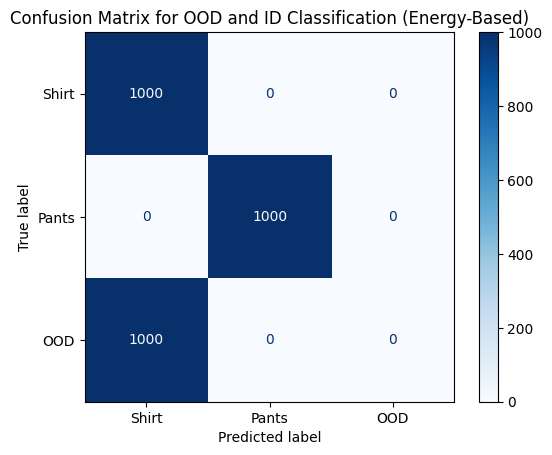

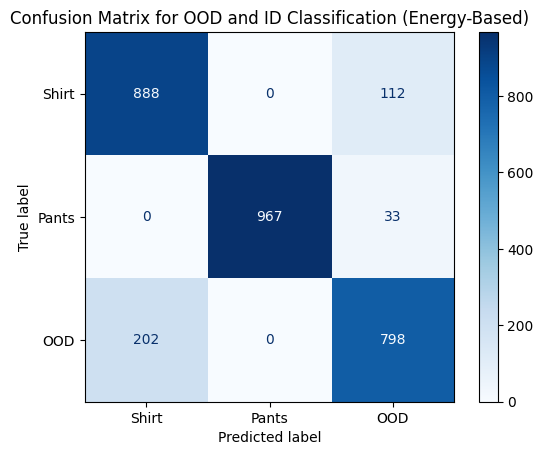

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Threshold value for the energy score
upper_threshold = best_f1_threshold  # Using the best F1 threshold from the previous calculation

# Classifying OOD examples based on energy scores
ood_classifications = np.where(ood_energy_scores >= upper_threshold, -1,  # classified as OOD
                               np.where(ood_energy_scores < upper_threshold, 0, -1))  # classified as ID

# Classifying ID examples based on energy scores
id_classifications = np.where(id_energy_scores >= upper_threshold, -1,  # classified as OOD
                              np.where(id_energy_scores < upper_threshold, id_true_labels, -1))  # classified as ID

# Combine OOD and ID classifications and true labels
all_predictions = np.concatenate([ood_classifications, id_classifications])
all_true_labels = np.concatenate([ood_true_labels, id_true_labels])

# Confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions, labels=[0, 1, -1])

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Shirt", "Pants", "OOD"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for OOD and ID Classification (Energy-Based)')
plt.show()


# Limitations of our approach thus far

* Focus on single OOD class: More reliable/accurate thresholds can/should be obtained using a wider variety (more classes) and larger sample of OOD data. This is part of the challenge of OOD detection which is that space of OOD data is vast. **Possible exercise**: Redo thresholding using all remaining classes in dataset.

## References and supplemental resources
* https://www.youtube.com/watch?v=hgLC9_9ZCJI
* Generalized Out-of-Distribution Detection: A Survey: https://arxiv.org/abs/2110.11334

# Glossary
* ID/OOD: In-distribution, out-of-distribution. Generally, the OOD instances can be defined as instances (x, y) sampled from an underlying distribution other than the training distribution P(Xtrain, Ytrain), where Xtrain and Ytrain are the training corpus and training label set, respectively.
* OOD instances with semantic shift: OOD instances with semantic shift refer to instances that do not belong to y_train. More specifically, instances with semantic shift may come from unknown categories or irrelevant tasks.
* OOD instances with covariate shift: OOD instances with non-semantic shift refer to the instances that belong to y_train but are sampled from a distribution other than x_train, e.g., a different domain/corpus/location.
* Closed-world assumption: an assumption that the training and test data are sampled from the same distribution. However, training data can rarely capture the entire distribution. In real-world scenarios, out-of-distribution (OOD) instances, which come from categories that are not known to the model, can often be present in inference phases.
* Inference-time OOD: After training, use some kind of scoring function to determine if test inputs are OOD or not.
* Output-based OOD: Output-based OOD detection methods leverage the model's output distribution to identify OOD instances. These methods typically involve analyzing the softmax scores, confidence scores, or other output statistics to detect anomalies.
